# Project: Community Detection and Network Resilience

## (a) Construct a network from the dataset. 

In [164]:
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
from itertools import takewhile
from functools import partial as part
import pickle

In [3]:
g = nx.read_gml("../data/netscience/netscience.gml")

## (b) Plot  its  degree  distribution,  then  compute  its  average  shortest  distance  and average clustering coefficient. 

### Degree distribution

In [170]:
def deg_dist_plot(g: nx.Graph, *args, plotter=plt, **kwargs):
    degs = [k for n,k in g.degree if k > 0]
    km, kM = min(degs), max(degs)
    plotter.scatter(range(km, kM+1), (np.bincount(degs)/len(degs))
                    [km:kM+1], *args, **kwargs)


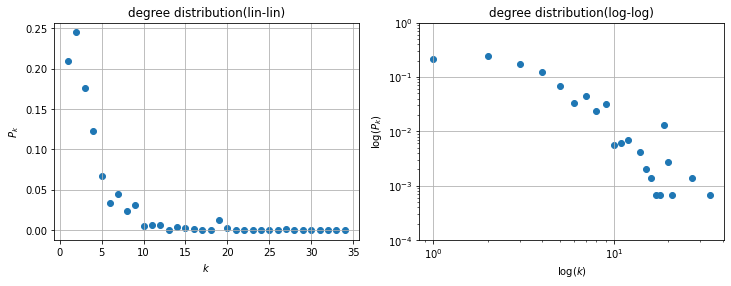

In [171]:
plt.figure(figsize=(12,4))
plt.subplot(121)
deg_dist_plot(g)
plt.xlabel("$k$")
plt.ylabel("$P_k$")
# plt.xscale("log")
# plt.yscale("log")
# plt.ylim([10**-4,1])
plt.grid(True)
plt.title("degree distribution(lin-lin)")
plt.subplot(122)
deg_dist_plot(g)
plt.xlabel("$\log(k)$")
plt.ylabel("$\log(P_k)$")
plt.xscale("log")
plt.yscale("log")
plt.ylim([10**-4,1])
plt.grid(True)
plt.title("degree distribution(log-log)")
plt.show()

from this degree distribution, we can see it obeys a power law.

### Average shortest distance

Since this network isn't a connected graph, so we just compute it's average shortest distance for it's giant component.

In [12]:
giant_subgraph = g.subgraph(max(nx.connected_components(g), key=len))

In [13]:
nx.average_shortest_path_length(giant_subgraph)

6.041867347935949

### Average clustering coefficient

In [14]:
nx.average_clustering(g)

0.6377905695067805

## (c) Use the Girvan-Newman algorithm to find its communities. 

In [41]:
maxNComm = 410
gncomm = nx.community.girvan_newman(g)
communities = list(takewhile(lambda c: len(c) <= maxNComm, gncomm))

with open("../out/gn-comm-finding.pkl","wb") as output:
    pickle.dump(communities,output)

In [42]:
[len(max(comm,key=len)) for comm in communities]

[200, 179, 176, 127, 127, 100, 100, 91, 91, 73, 73, 73, 73, 53]

## (d) Perform  (i)  a  random  attack  and  (ii)  a  targeted  attack  
on  the  network  by 
removing nodes from the network. Plot the size of the giant component against 
the fraction of nodes removed like p.17–18 in Lecture 9. 

In [117]:
def random_attack(g: nx.Graph, p):
    N = g.number_of_nodes()
    C = np.floor(N*(1-p)).astype(int)
    choices = np.random.choice(g.nodes, size=C, replace=False)
    return g.subgraph(choices)


def target_attack(g: nx.Graph, p):
    N = g.number_of_nodes()
    C = np.floor(N*(1-p)).astype(int)
    choices = [node for node, k in sorted(
        g.degree, key=lambda item:item[1])[:C]]
    return g.subgraph(choices)


def size_of_giant(g:nx.Graph):
    giant = g.subgraph(max(nx.connected_components(g), key=len))
    return giant.number_of_nodes()

In [128]:
np.random.seed(5003)
nsample = 50
ps = np.arange(0, 1, .02)
N = size_of_giant(g)
target_attack_survive = np.array(
    [*map(size_of_giant, map(part(target_attack, g), ps))])/N
random_attack_survive = np.array(
    [[*map(size_of_giant, map(part(random_attack, g), ps))] for _ in range(nsample)]).mean(axis=0)/N


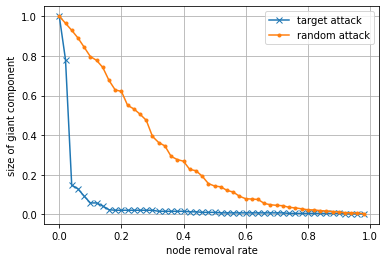

In [131]:
plt.plot(ps,target_attack_survive,marker='x',label="target attack")
plt.plot(ps,random_attack_survive,marker='.',label="random attack")
plt.xlabel("node removal rate")
plt.ylabel("size of giant component")
plt.legend()
plt.grid(True)
plt.show()